# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. EDA

## 1.1. Portfolio

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


OFFER TYPES: 
- 2 Informational offers - provide no rewards, last either 3 (+social channel) or 4 days (+web channel). 
- 4 BOGO types (difficulty=reward) - 2 lasting for 5 days (one easier - \\$5, one more difficult - \\$10) and 2 lasting for 7 days (one easier - \\$5, one more difficult - \\$10) 
- 4 discounts - 2 lasting for 7 days (one easier - \\$7d / \\$3r, one more difficult - \\$10d / \\$2r) + 2 lasting for 10 days (one easier - \\$10d / \\$2r, one more difficult - \\$20d / \\$5r). Both difficult versions of duration types differ in channels - shorter--> no social, longer--> no social+no mobile). So the longest, the most difficult offer is distributed only via web/email. Difficulty correlates with instancy of channels.


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Reencode offer_type as dummy variables:

In [4]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)

Reencode channels as dummy variables:

In [5]:
for channel in portfolio.channels[1]:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in str(x)else 0)

Note: email is useless because it is in every offer type. <br>
One could also encode Channels differently as dummies (e.g. email,mobile,social = 1; web,email = 2, etc)

In [6]:
portfolio_clean = portfolio[['id', 'bogo', 'discount', 'informational', 
                            'email', 'web', 'mobile', 'social', 
                            'reward', 'difficulty', 'duration']]

In [7]:
portfolio_clean

,id,bogo,discount,informational,email,web,mobile,social,reward,difficulty,duration
0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0,1,1,10,10,7
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1,10,10,5
2,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0,0,0,4
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0,5,5,7
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0,5,20,10
5,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1,3,7,7
6,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1,2,10,10
7,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,0,1,1,0,0,3
8,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1,5,5,5
9,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0,2,10,7


## 1.2. Profile

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
if (profile.id.value_counts() > 1).sum() == 0:
    print("profile's ids are all unique")

profile's ids are all unique


In [10]:
print(f"there are {profile.shape[0]} customers in profile")

there are 17000 customers in profile


### Dealing with missing values in Profile

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Commentary: There are missing values in gender, age and income. Age missing values are encoded 118. Missing values in 'gender' column are recorded as NoneType, in 'income' column - as NaNs. 

In [12]:
type(profile.gender[0]), type(profile.income[0]), 

(NoneType, numpy.float64)

In [13]:
# Replace NoneType with Nans in gender column
profile.gender.fillna(value=np.nan, inplace=True)

In [14]:
type(profile.gender[0])

float

In [15]:
# Replace 118 with Nans in age column:
profile.age.replace(118, np.nan, inplace=True)

In [16]:
#Change type of 'became_member_on' column from int to time:
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(str), format="%Y/%m/%d")

In [17]:
# Reencode 'gender' as dummies:
profile = pd.concat([profile, pd.get_dummies(profile['gender'])], axis=1)

In [18]:
profile.head()

,gender,age,id,became_member_on,income,F,M,O
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0


In [19]:
profile.describe()

,age,income,F,M,O
count,14825.000000,14825.000000,17000.000000,17000.000000,17000.000000
mean,54.393524,65404.991568,0.360529,0.499059,0.012471
std,17.383705,21598.299410,0.480168,0.500014,0.110977
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,0.000000,0.000000,0.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000


In [20]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

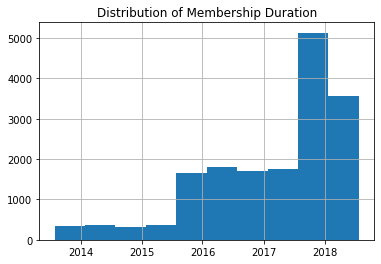

In [21]:
profile.became_member_on.hist();
plt.title("Distribution of Membership Duration");

In [22]:
profile.became_member_on.min(), profile.became_member_on.max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

Commentary: the earliest member is since July 29, 2013; the most recent member - since July 26, 2018

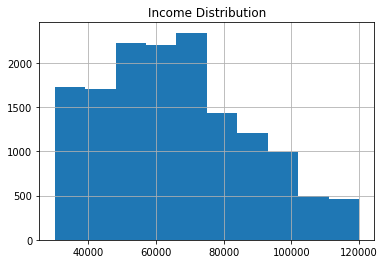

In [23]:
profile.income.hist();
plt.title("Income Distribution");

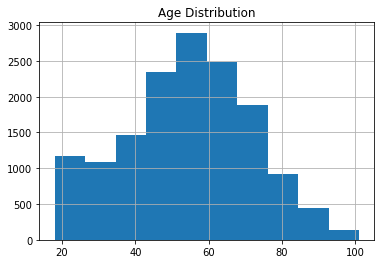

In [24]:
profile.age.hist();
plt.title("Age Distribution");

Commentary: the offer program is mostly for elderly people. The average age is 54 years.
Hypothesis: young people won't probably response to ads.

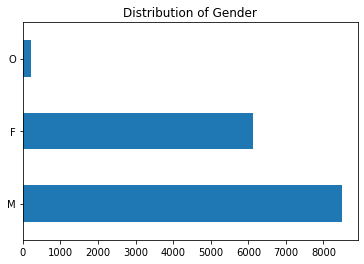

In [25]:
profile.gender.value_counts().plot.barh();
plt.title("Distribution of Gender");

Commentary: there are more men in the offer program than females. 

In [26]:
# reorder columns to have id as first and drop 'gender' column
profile_clean = profile[['id', 'became_member_on', 'age', 'F', 'M', 'O', 'income']]

## 1.3 Transcript

In [27]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
transcript.shape

(306534, 4)

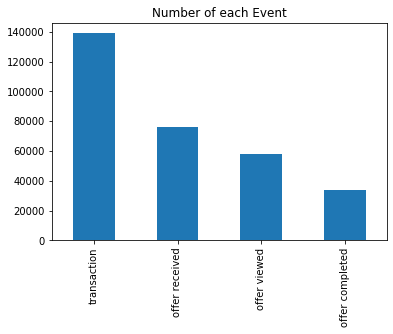

In [29]:
transcript.event.value_counts().plot.bar();
plt.title("Number of each Event");

Note: transation != offer completed. People may buy a product without reacting to an offer. 
<br> "Offer completed" are in minority. Potentially class imbalance problem!

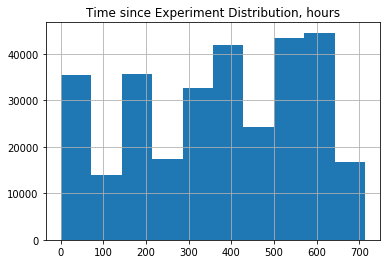

In [30]:
transcript.time.hist();
plt.title("Time since Experiment Distribution, hours");

In [31]:
print(f"experiment lasted for max {transcript.time.max()/24} days")

experiment lasted for max 29.75 days


Convert hours to days:

In [32]:
transcript['time_days'] = transcript.time/24

Let's see the typical transaction record for one person:

In [33]:
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,time_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0.25
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,5.50
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,5.50
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,6.00
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,7.00
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,9.00
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,9.25
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,10.00
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,15.75


In [34]:
value_normalized = json_normalize(transcript['value'])

In [35]:
value_normalized.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
# merging the two columns 'offer id' and 'offer_id' into new one 'id'
value_normalized['id'] = value_normalized['offer id'].fillna(value_normalized['offer_id'])

In [37]:
# dropping the redundant columns 'offer id', 'offer_id'
value_normalized = value_normalized.drop(['offer id', 'offer_id'], axis=1)

In [38]:
value_normalized.rename(columns={value_normalized.columns[1]:'rewarded'}, inplace=True)

In [39]:
value_normalized.head()

,amount,rewarded,id
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [40]:
# how many non empty reward values are there?
(~value_normalized.rewarded.isna()).sum()

33579

In [41]:
# join new df with transcript 
transcript_clean = transcript.join(value_normalized)

In [42]:
# dropping 'value' column
transcript_clean = transcript_clean.drop(['value'], axis=1)

In [43]:
transcript_clean.head()

,person,event,time,time_days,amount,rewarded,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Combining datasets

In [44]:
profile_clean.shape, transcript.shape

((17000, 7), (306534, 5))

In [47]:
profile_clean.head()

,person,became_member_on,age,F,M,O,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,55.0,1,0,0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,75.0,1,0,0,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,NaN


In [46]:
# renaming 'id' column to 'person' in profile_clean dataset so that we can later merge it with transcript
profile_clean.rename(columns={profile_clean.columns[0]:'person'}, inplace=True)

/Users/kbosko/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [48]:
df = profile_clean.merge(transcript_clean, on='person', how='right')

In [49]:
starbucks = df.merge(portfolio_clean, on='id', how='left')

In [55]:
# dropping 'id' (which stands for offer_id) column after merging all datasets
starbucks = starbucks.drop(['id'], axis=1)

In [60]:
starbucks.head(3)

,person,became_member_on,age,F,M,O,income,event,time,time_days,...,bogo,discount,informational,email,web,mobile,social,reward,difficulty,duration
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer received,168,7.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,10.0,7.0
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer viewed,216,9.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,10.0,7.0
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer received,336,14.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,20.0,10.0


In [61]:
starbucks.shape

(306534, 22)

## Feature Engineering:

In [70]:
starbucks['membership_days'] = starbucks.became_member_on.max()-starbucks.became_member_on

In [73]:
starbucks['membership_days'] = starbucks['membership_days'].apply(lambda x: x.days)

In [76]:
starbucks.head()

,person,became_member_on,age,F,M,O,income,event,time,time_days,...,discount,informational,email,web,mobile,social,reward,difficulty,duration,membership_days
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer received,168,7.0,...,1.0,0.0,1.0,1.0,1.0,0.0,2.0,10.0,7.0,529
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer viewed,216,9.0,...,1.0,0.0,1.0,1.0,1.0,0.0,2.0,10.0,7.0,529
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer received,336,14.0,...,1.0,0.0,1.0,1.0,0.0,0.0,5.0,20.0,10.0,529
3,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,offer viewed,348,14.5,...,1.0,0.0,1.0,1.0,0.0,0.0,5.0,20.0,10.0,529
4,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,transaction,360,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529
